In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Circle, Arrow
import time
import os
import copy
!pip install pytorchvis
!pip install torchsummary
from torchsummary import summary
from pytorchvis.visualize_layers import VisualizeLayers
from PIL import Image as PImage
import io
import math
from scipy.spatial import distance as dist
import cv2

plt.ion()   # interactive mode

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


**initialize variables**

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
# load the Pytorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True).to(device)

**Dataloader**

In [4]:
IX_path = 'Images/dog.jpg'

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize([224, 224]),
   transforms.ToTensor(),
   normalize
])
shape = np.array([224.0, 224.0])
IX = plt.imread(IX_path)
# IY = plt.imread(IY_path)
IX = cv2.resize(IX, (616, 616))


scaling_ratio = 91 / 100
width = int(616 * scaling_ratio)
height = int(616 * scaling_ratio)

dsize = (width, height)
rescale = cv2.resize(IX, dsize)
full_rescale = np.full([616, 616, 3], 255, dtype=np.uint8)
# full_rescale = np.ones((616, 616, 3),dtype=np.uint8)
padding = IX.shape[0]//2 - rescale.shape[0]//2
full_rescale[padding:rescale.shape[0]+padding, padding:rescale.shape[0]+padding, :] = rescale
IY = full_rescale
IY_trand = preprocess(PImage.fromarray(full_rescale))
IY_trand.unsqueeze_(0)

# used to reshape features to original image
Xscale = 1.0 * np.array(IX.shape[:2]) / shape
# Yscale = 1.0 * np.array(IY.shape[:2]) / shape
Yscale = Xscale
IX_trand = preprocess(PImage.open(IX_path))
IX_trand.unsqueeze_(0)

# IY_trand = preprocess(PImage.open(IY_path))
# IY_trand.unsqueeze_(0)
IY_trand.size()

torch.Size([1, 3, 224, 224])

**Select and visualize the first image**

torch.Size([1, 3, 224, 224])


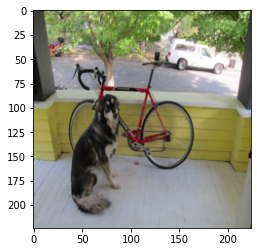

In [5]:
# Make a grid from batch
print(IX_trand.size())
out = torchvision.utils.make_grid(IX_trand)
imshow(out)

**Select and visualize the second image**


torch.Size([1, 3, 224, 224])


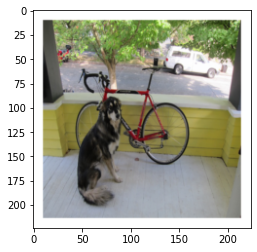

In [6]:
# Make a grid from batch
print(IY_trand.size())
out = torchvision.utils.make_grid(IY_trand)
imshow(out)

**summary of the model**

In [7]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Output of the first image**

In [8]:
# create an object of VisualizeLayers and initialize it with the model and 
# the layers whose output you want to visualize
vis = VisualizeLayers(model,layers='all')
# pass the input and get the output
output = model(IX_trand.to(device))
# get the intermediate layers output which was passed during initialization
interm_output = vis.get_interm_output()

# pool2 = interm_output['features.9_pooling_MaxPool2d'].cpu() 16
pool3 = interm_output['features.16_pooling_MaxPool2d'].cpu()
# pool4 = interm_output['features.23_pooling_MaxPool2d'].cpu()
# pool5 = interm_output['features.30_pooling_MaxPool2d'].cpu()

features_container_Sequential
	 features.0_conv_Conv2d
	 features.1_activation_ReLU
	 features.2_conv_Conv2d
	 features.3_activation_ReLU
	 features.4_pooling_MaxPool2d
	 features.5_conv_Conv2d
	 features.6_activation_ReLU
	 features.7_conv_Conv2d
	 features.8_activation_ReLU
	 features.9_pooling_MaxPool2d
	 features.10_conv_Conv2d
	 features.11_activation_ReLU
	 features.12_conv_Conv2d
	 features.13_activation_ReLU
	 features.14_conv_Conv2d
	 features.15_activation_ReLU
	 features.16_pooling_MaxPool2d
	 features.17_conv_Conv2d
	 features.18_activation_ReLU
	 features.19_conv_Conv2d
	 features.20_activation_ReLU
	 features.21_conv_Conv2d
	 features.22_activation_ReLU
	 features.23_pooling_MaxPool2d
	 features.24_conv_Conv2d
	 features.25_activation_ReLU
	 features.26_conv_Conv2d
	 features.27_activation_ReLU
	 features.28_conv_Conv2d
	 features.29_activation_ReLU
	 features.30_pooling_MaxPool2d
avgpool_pooling_AdaptiveAvgPool2d
classifier_container_Sequential
	 classifier.0_linear_Line

In [9]:
featureMap = []
DX1 = np.zeros(shape=(784,256))
pool3_flat = np.reshape(pool3, [-1, 784]).numpy()
for i in range(pool3_flat.shape[1]):
    for kernel in pool3_flat:
        featureMap.append(kernel[i])
    DX1[i] = featureMap
    featureMap = []

Number of output maps: 256


<Figure size 432x288 with 0 Axes>

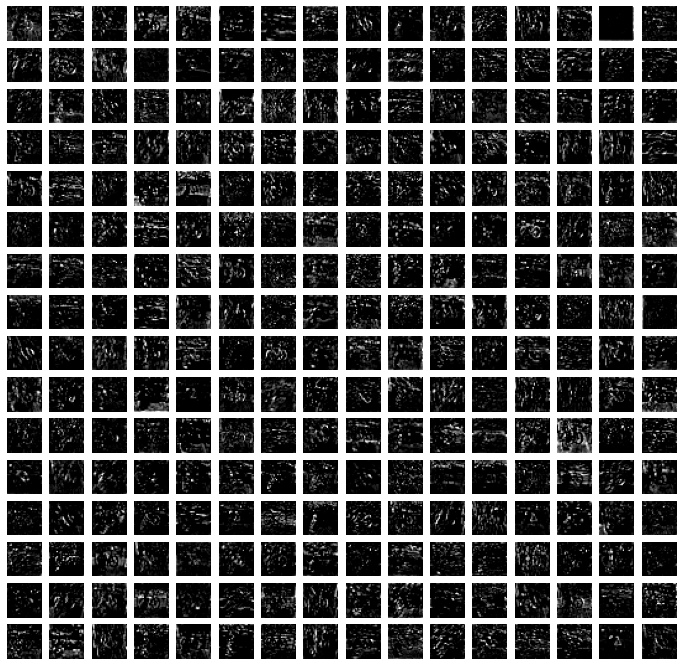

In [10]:
vis.plot_featuremaps(pool3,name='fmaps',color_map='gray',savefig=False)

**Ouput of the second image**

In [11]:
# create an object of VisualizeLayers and initialize it with the model and 
# the layers whose output you want to visualize
vis = VisualizeLayers(model,layers='all')
# pass the input and get the output
output = model(IY_trand.to(device))
# get the intermediate layers output which was passed during initialization
interm_output = vis.get_interm_output()

# pool2 = interm_output['features.9_pooling_MaxPool2d'].cpu()
pool3 = interm_output['features.16_pooling_MaxPool2d'].cpu()
# pool4 = interm_output['features.23_pooling_MaxPool2d'].cpu()
# pool5 = interm_output['features.30_pooling_MaxPool2d'].cpu()

features_container_Sequential
	 features.0_conv_Conv2d
	 features.1_activation_ReLU
	 features.2_conv_Conv2d
	 features.3_activation_ReLU
	 features.4_pooling_MaxPool2d
	 features.5_conv_Conv2d
	 features.6_activation_ReLU
	 features.7_conv_Conv2d
	 features.8_activation_ReLU
	 features.9_pooling_MaxPool2d
	 features.10_conv_Conv2d
	 features.11_activation_ReLU
	 features.12_conv_Conv2d
	 features.13_activation_ReLU
	 features.14_conv_Conv2d
	 features.15_activation_ReLU
	 features.16_pooling_MaxPool2d
	 features.17_conv_Conv2d
	 features.18_activation_ReLU
	 features.19_conv_Conv2d
	 features.20_activation_ReLU
	 features.21_conv_Conv2d
	 features.22_activation_ReLU
	 features.23_pooling_MaxPool2d
	 features.24_conv_Conv2d
	 features.25_activation_ReLU
	 features.26_conv_Conv2d
	 features.27_activation_ReLU
	 features.28_conv_Conv2d
	 features.29_activation_ReLU
	 features.30_pooling_MaxPool2d
avgpool_pooling_AdaptiveAvgPool2d
classifier_container_Sequential
	 classifier.0_linear_Line

In [12]:
featureMap = []
DY1 = np.zeros(shape=(784,256))
pool3_flat = np.reshape(pool3, [-1, 784]).numpy()
for i in range(pool3_flat.shape[1]):
    for kernel in pool3_flat:
        featureMap.append(kernel[i])
    DY1[i] = featureMap
    featureMap = []

torch.Size([1, 256, 28, 28])
Number of output maps: 256


<Figure size 432x288 with 0 Axes>

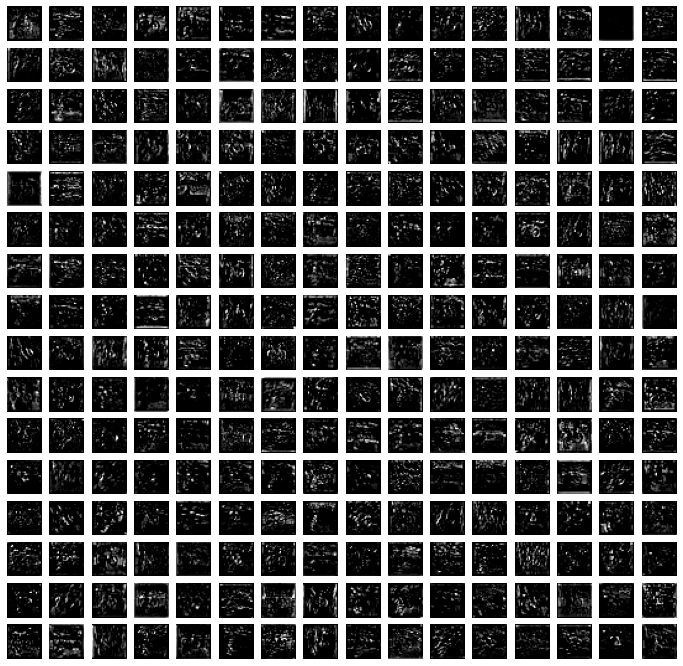

In [13]:
# pool3 = 	 features.16_pooling_MaxPool2d
# pool4 = 	 features.23_pooling_MaxPool2d
# pool5 = 	 features.30_pooling_MaxPool2d
print(pool3.size())
vis.plot_featuremaps(pool3, name='fmaps',color_map='gray',savefig=False)

In [14]:
print(f"pool3 shape: {pool3[0].shape}")
print(f"pool3 first el: {pool3[0][0].shape}")
print(f"DX1 shape: {DX1.shape}")

DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)


pool3 shape: torch.Size([256, 28, 28])
pool3 first el: torch.Size([28, 28])
DX1 shape: (784, 256)


#### Utils

In [15]:
def pairwise_distance(X, Y):
    assert len(X.shape) == len(Y.shape)
    N = X.shape[0]
    M = Y.shape[0]
    res = np.zeros([M, N])
    for i in range(M):
        for j in range(N):
            res[i][j] = np.linalg.norm(X[j] - Y[i])
    return res

def match(PD):
    seq = np.arange(PD.shape[0]) # create array of a certain shape from 0 to len
    amin1 = np.argmin(PD, axis=1) # return smallest index from each list
    C = np.array([seq, amin1]).transpose()
    min1 = PD[seq, amin1] # array of the minimum distances
    mask = np.zeros_like(PD) # return an array of zeros of the same shape as DP
    mask[seq, amin1] = 1
    masked = np.ma.masked_array(PD, mask) # PD without the smallest values
    min2 = np.amin(masked, axis=1) # return smallest num in list
    return C, np.array(min2/min1)

def match_max(PD):
    seq = np.arange(PD.shape[0])
    amax1 = np.argmin(PD, axis=1)
    C = np.array([seq, amax1]).transpose()
    return C

#### Obtain the distance matrix

In [16]:
PD1 = pairwise_distance(DX1, DY1)

In [17]:
seq = np.array([[i, j] for i in range(28)
                for j in range(28)], dtype='int32')

X = np.array(seq, dtype='float32') * 8.0 + 4.0 #8 is the descriptor size ?
Y = np.array(seq, dtype='float32') * 8.0 + 4.0

# prematch and select points
C_all, quality = match(PD1)
print(f"C_all shape: {C_all.shape}")
print(f"C_all: {C_all[0]}")
print(f"Quality shape: {quality.shape}")
theta_max = np.max(quality) # large starting threshold that only confident inliers satisfy
print(f"Absolute theta max: {theta_max}")

# Don't stop until threshold allows at least 50 distances.
# Automatic threshold to select the most reliable 128 distances (high quality ratio)
# A large number of features points are selected using low threshold to filter out irrelevant points.
while np.where(quality >= theta_max)[0].shape[0] <= 50:
    theta_max -= 0.01

print(f"Theta_max: {theta_max}")
print(f"X shape: {X.shape}")

# tell me where in quality, entries are >= theta_max
C = C_all[np.where(quality >= theta_max)]

cnt = C.shape[0] # number of features with > theta_max 50
print(f"Number of match: {cnt}")
# select prematched feature points
X, Y = X[C[:, 1]], Y[C[:, 0]]

C_all shape: (784, 2)
C_all: [  0 476]
Quality shape: (784,)
Absolute theta max: 3.2277088702207566
Theta_max: 1.8377088702207824
X shape: (784, 2)
Number of match: 51


# Display features


Number of features: 51


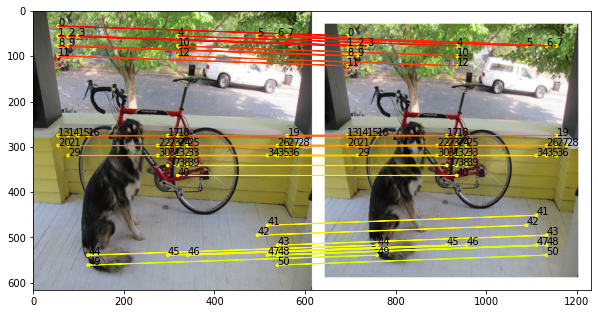

In [18]:
Xscaled = X*Xscale
Yscaled = Y*Yscale

res = np.zeros(shape=(IX.shape[0],IX.shape[1]+ IY.shape[1], 3), dtype=np.uint8)
res[:, :IX.shape[1], :] = IX
res[:, IY.shape[1]:, :] = IY

fig,ax = plt.subplots(1, figsize=(10,14))
ax.set_aspect('equal')
ax.imshow(res)
print(f"Number of features: {Xscaled.shape[0]}")
cmap = get_cmap("hsv")
for i, pnt in enumerate(Xscaled):
    src_x = int(pnt[1])
    src_y = int(pnt[0])
    dst_x = int(Yscaled[i][1]+IX.shape[1])
    dst_y = int(Yscaled[i][0])
    circ_src = Circle((src_x,src_y), 3, color="yellow")
    ax.add_patch(circ_src)
    ax.annotate(i, (src_x, src_y))
    circ_dst = Circle((dst_x,dst_y), 3, color="yellow")
    ax.add_patch(circ_dst)
    ax.annotate(i, (dst_x, dst_y))
    line = Arrow(src_x, src_y, dst_x-src_x, dst_y-src_y, 2, color= cmap(i))
    ax.add_patch(line)

plt.show()

**Show features in one image**

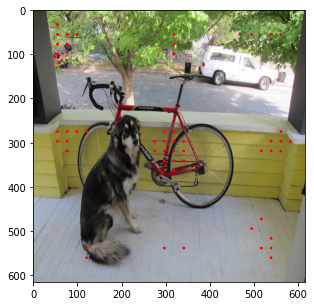

In [19]:
features_src = X*Xscale
fig,ax = plt.subplots(1, figsize=(5,5))
ax.set_aspect('equal')
ax.imshow(IX)

for i, pnt in enumerate(features_src):
    src_x = int(pnt[1])
    src_y = int(pnt[0])
    circ = Circle((src_x,src_y), 2, color="red")
    ax.add_patch(circ)



**Show features second image**

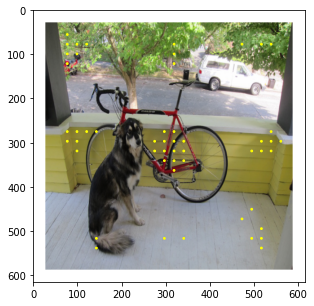

In [20]:
features_dst = Y*Yscale
fig,ax = plt.subplots(1, figsize=(5,5))
ax.set_aspect('equal')
ax.imshow(IY)
# ax.imshow(cv2.resize(IY, (224, 224)))

for i, pnt in enumerate(features_dst):
    src_x = int(pnt[1])
    src_y = int(pnt[0])
    circ = Circle((src_x,src_y), 2, color="yellow")
    ax.add_patch(circ)

**show differences**

In [21]:
difference_listX = []
difference_listY = []
distance_list = []
coordinates = []
for i, pnt in enumerate(Xscaled):
    src_x = (pnt[1])
    src_y = (pnt[0])
    dst_x = (Yscaled[i][1])
    dst_y = (Yscaled[i][0])
    difference_listX.append(src_x - dst_x)
    difference_listY.append(src_y - dst_y)
    distance_list.append(dist.euclidean((src_x, src_y), (dst_x, dst_y)))
    coordinates.append(dst_x/616)
    coordinates.append(dst_y/616)